This notebook solves the tracking issue by using [SAM2](https://github.com/facebookresearch/segment-anything-2/tree/main).
Here I use the pretrained model to segment the Nuclei in the video.
The output is a mask for each object in each frame and the x,y coordinates centers of each object in each frame.

# Table of Contents for this Notebook
#### 1. Imports
#### 2. Import data
#### 3. get the masks and centers
#### 4. Track multiple objects in the video
#### 5. Track the objects through frames
#### 6. Visualize the tracking and output the data

## 1. Imports

In [1]:
import csv
import gc
import logging
import os
import pathlib
import socket
import sys
from datetime import datetime

import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from csbdeep.utils import Path, normalize
from PIL import Image
from sam2.build_sam import build_sam2, build_sam2_video_predictor
from sam2.sam2_image_predictor import SAM2ImagePredictor
from skimage import io
from skimage.measure import label, regionprops
from stardist import fill_label_holes, random_label_cmap
from stardist.data import test_image_nuclei_2d
from stardist.matching import matching_dataset
from stardist.models import StarDist2D
from stardist.plot import render_label
from torchvision import models

sys.path.append("../../../utils/")
from SAM2_utils import (
    delete_recorded_memory_history,
    export_memory_snapshot,
    generate_random_coords,
    show_mask,
    show_points,
    start_record_memory_history,
    stop_record_memory_history,
)

2024-08-09 14:18:14.638384: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 14:18:14.649199: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 14:18:14.652668: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 14:18:14.661609: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-09 14:18:15.297757: W tensorflow/compiler/tf2

## 2. Import data

In [2]:
# load in the model and the predictor
sam2_checkpoint = pathlib.Path("../../../data/models/sam2/sam2_hiera_tiny.pt").resolve()
model_cfg = "sam2_hiera_t.yaml"
predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint)

# set the path to the video
tiff_dir = pathlib.Path(
    "../../../2.cellprofiler_ic_processing/illum_directory_test_small/20231017ChromaLive_6hr_4ch_MaxIP/C-02_F0001/"
).resolve(strict=True)
video_dir = pathlib.Path(
    "../../../2.cellprofiler_ic_processing/illum_directory_test_small/20231017ChromaLive_6hr_4ch_MaxIP/C-02_F0001/jpeg/"
).resolve()

video_dir.mkdir(exist_ok=True)
# Assuming video_dir is defined as a pathlib.Path object
for tiff_file in tiff_dir.glob("*.tiff"):
    jpeg_file = pathlib.Path(video_dir, tiff_file.stem + ".jpeg")
    if not jpeg_file.exists():
        try:
            with Image.open(tiff_file) as img:
                # Convert the image to 8-bit per channel
                img = img.convert("L")
                img.save(jpeg_file)
        except Exception as e:
            print(f"Failed to convert {tiff_file}: {e}")

# sort the files by name
jpeg_files = sorted(video_dir.glob("*.jpeg"))
len(jpeg_files)

52

In [3]:
# for each file, extract the Well, FOV, Channel and make a nested dir for file, well, fov, channel and keep all timepoints in that dir
for jpeg_file in jpeg_files:
    well = jpeg_file.stem.split("_")[0]
    fov = jpeg_file.stem.split("_")[1]
    channel = jpeg_file.stem.split("_")[4]
    timepoints_dir = pathlib.Path(f"{video_dir}_{well}_{fov}_{channel}")
    timepoints_dir.mkdir(exist_ok=True, parents=True)
    jpeg_file.rename(timepoints_dir / jpeg_file.name)


# select one well to copy
well_to_cp = pathlib.Path(
    "../../../2.cellprofiler_ic_processing/illum_directory_test_small/20231017ChromaLive_6hr_4ch_MaxIP/C-02_F0001/jpeg_C-02_F0001_C01"
).resolve(strict=True)
# copy this dir to the current dir
import shutil

if pathlib.Path("./videos/jpeg_C-02_F0001_C01").exists():
    shutil.rmtree(pathlib.Path("./videos/jpeg_C-02_F0001_C01").resolve())
    shutil.copytree(well_to_cp, pathlib.Path("./videos/jpeg_C-02_F0001_C01").resolve())
elif not pathlib.Path("./videos/jpeg_C-02_F0001_C01").exists():
    shutil.copytree(well_to_cp, pathlib.Path("./videos/jpeg_C-02_F0001_C01").resolve())

In [4]:
video_dir = pathlib.Path("./videos/jpeg_C-02_F0001_C01/").resolve(strict=True)
# rename files to 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
jpeg_files = sorted(video_dir.glob("*.jpeg"))
for i, jpeg_file in enumerate(jpeg_files):
    jpeg_file.rename(video_dir / f"{i}.jpeg")

## 3. Get initial masks and centers via StarDist

In [5]:
# load the star dist model
StarDist2D.from_pretrained()
model = StarDist2D.from_pretrained("2D_versatile_fluo")

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


I0000 00:00:1723234699.252237  313691 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-09 14:18:19.255072: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
# get files in the directory
files = list(Path(video_dir).glob("*.jpeg"))
# posix path to string
files = [str(f) for f in files]
# sort the files by name
# downsample the image
for f in files:
    img = io.imread(f)
    # downsample the image
    downsampled_img = img[::10, ::10]
    # save the downsampled image in place of the original image
    io.imsave(f, downsampled_img)


# scan all the JPEG, jpg, jpeg, JPG files in the directory
frame_names = []
if len(list(video_dir.glob("*.jpeg"))) > 0:
    frame_names.append(list(video_dir.glob("*.jpeg")))
if len(list(video_dir.glob("*.jpg"))) > 0:
    frame_names.append(list(video_dir.glob("*.jpg")))
if len(list(video_dir.glob("*.jpeg"))) > 0:
    frame_names.append(list(video_dir.glob("*.JPEG")))
if len(list(video_dir.glob("*.JPG"))) > 0:
    frame_names.append(list(video_dir.glob("*.JPG")))

# flatten the list
frame_names = [item for sublist in frame_names for item in sublist]
frame_names = [str(f) for f in frame_names]
frame_names = sorted(frame_names, key=lambda x: int(x.split("/")[-1].split(".")[0]))
frame_names

['/home/lippincm/Documents/live_cell_timelapse_apoptosis/3.optimizing_CP/run_sam/notebooks/videos/jpeg_C-02_F0001_C01/0.jpeg',
 '/home/lippincm/Documents/live_cell_timelapse_apoptosis/3.optimizing_CP/run_sam/notebooks/videos/jpeg_C-02_F0001_C01/1.jpeg',
 '/home/lippincm/Documents/live_cell_timelapse_apoptosis/3.optimizing_CP/run_sam/notebooks/videos/jpeg_C-02_F0001_C01/2.jpeg',
 '/home/lippincm/Documents/live_cell_timelapse_apoptosis/3.optimizing_CP/run_sam/notebooks/videos/jpeg_C-02_F0001_C01/3.jpeg',
 '/home/lippincm/Documents/live_cell_timelapse_apoptosis/3.optimizing_CP/run_sam/notebooks/videos/jpeg_C-02_F0001_C01/4.jpeg',
 '/home/lippincm/Documents/live_cell_timelapse_apoptosis/3.optimizing_CP/run_sam/notebooks/videos/jpeg_C-02_F0001_C01/5.jpeg',
 '/home/lippincm/Documents/live_cell_timelapse_apoptosis/3.optimizing_CP/run_sam/notebooks/videos/jpeg_C-02_F0001_C01/6.jpeg',
 '/home/lippincm/Documents/live_cell_timelapse_apoptosis/3.optimizing_CP/run_sam/notebooks/videos/jpeg_C-02_F00

### Plot the segementation
Plot the following:
- the original image
- the segmentation
- the x,y centers of the segmentation
- the extracted masks

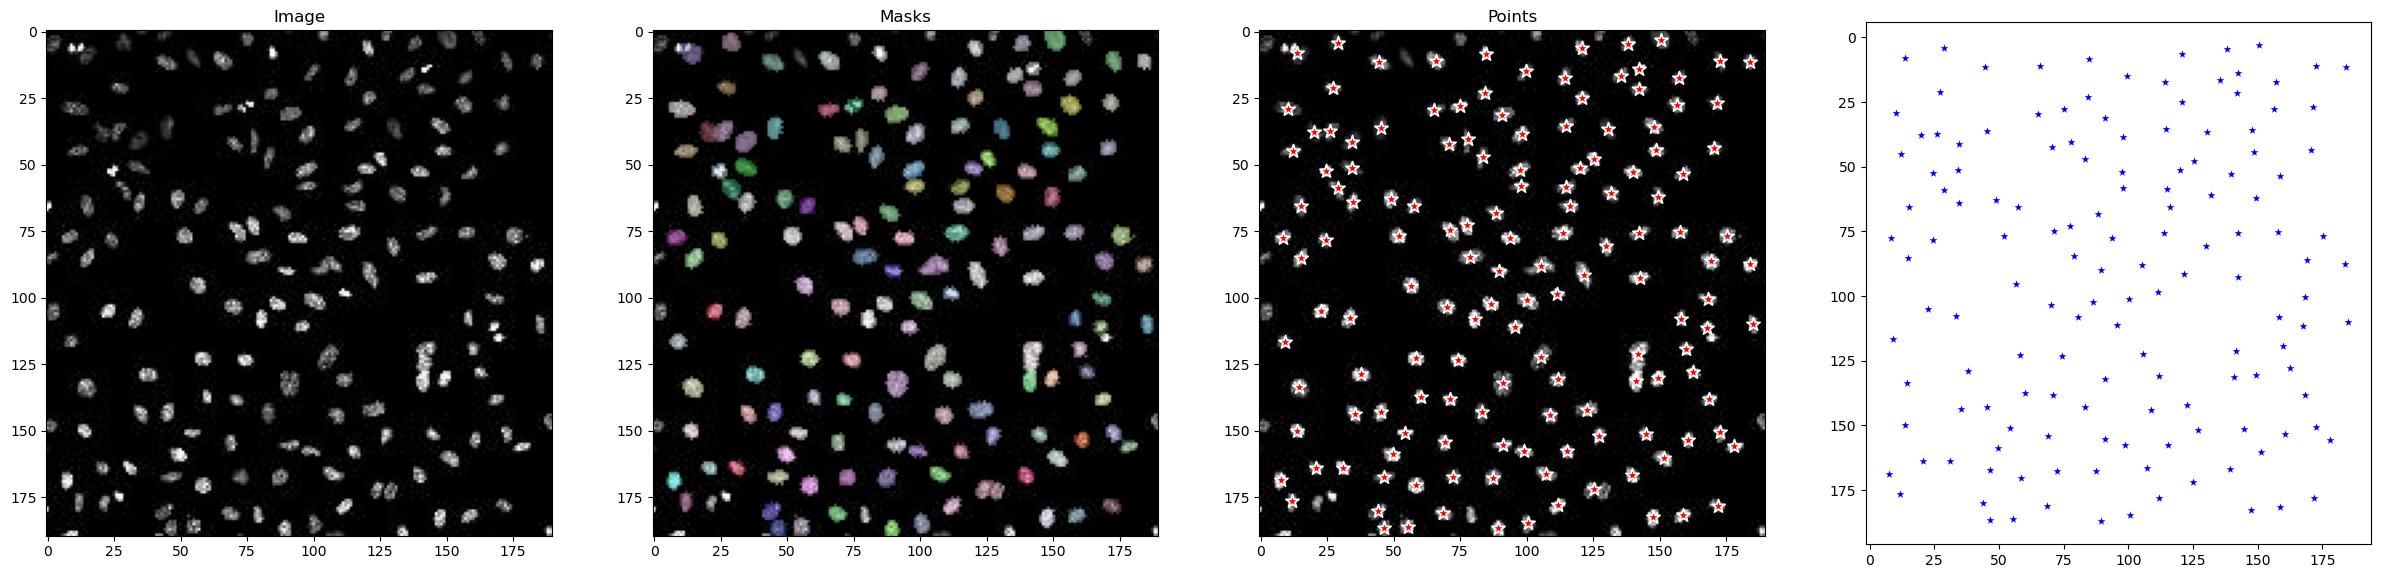

In [7]:
img = io.imread(frame_names[0])
labels, _ = model.predict_instances(normalize(img))
# get the masks for the first frame and the xy coordinates
# get the coordinates of the masks

# convert the labels into position coordinates
regions = regionprops(label(labels))
coords = np.array([r.centroid for r in regions])

# plot the points and the masks and the image side by side by side
fig, ax = plt.subplots(1, 4, figsize=(30, 15))
ax[0].imshow(img, cmap="gray")
ax[0].set_title("Image")
ax[1].imshow(render_label(labels, img=img))
ax[1].set_title("Masks")
ax[2].imshow(img, cmap="gray")
ax[2].scatter(
    coords[:, 1],
    coords[:, 0],
    color="red",
    marker="*",
    s=100,
    edgecolor="white",
    linewidth=1.25,
)
ax[2].set_title("Points")
coords = coords[:, [1, 0]]
ax[3].invert_yaxis()
# make the aspect ratio equal
ax[3].set_aspect("equal")
show_points(coords, np.ones(len(coords)), ax[3])

## 4. Track multiple objects in the video

In [8]:
# initialize the state
inference_state = predictor.init_state(
    video_path=str(video_dir), offload_video_to_cpu=True, offload_state_to_cpu=True
)
predictor.reset_state(inference_state)

frame loading (JPEG): 100%|██████████| 13/13 [00:00<00:00, 83.87it/s]


In [9]:
# get the first frame coords
points = coords
labels = np.ones(coords.shape[0], dtype=np.int32)
print(points.shape, labels.shape)

(144, 2) (144,)


In [10]:
prompts = {}
ann_frame_idx = 0
ann_obj_idx = 1
samples = 1
negative_sampling = False  # set True to generate negative samples for better training
# loop through the points and add them to the state and get the masks
for point, _label in zip(points, labels):
    _label = np.array([_label], dtype=np.int32)
    point = np.array([point], dtype=np.float32)
    random_points, random_labels = generate_random_coords(
        img=img, coords=point, samples=samples
    )
    if negative_sampling:
        point = np.concatenate([point, random_points], axis=0)
        _label = np.concatenate([_label, random_labels], axis=0)
    # add the points to the state
    _, out_obj_ids, out_mask_logits = predictor.add_new_points(
        inference_state=inference_state,
        frame_idx=ann_frame_idx,
        obj_id=ann_obj_idx,
        points=point,
        labels=_label,
    )
    # save the prompts
    prompts[ann_obj_idx] = {
        "points": point,
        "labels": _label,
        "out_obj_ids": out_obj_ids[0],
        "out_mask_logits": out_mask_logits[0].detach().cpu().numpy(),
    }
    # increment the object index for this frame
    ann_obj_idx += 1

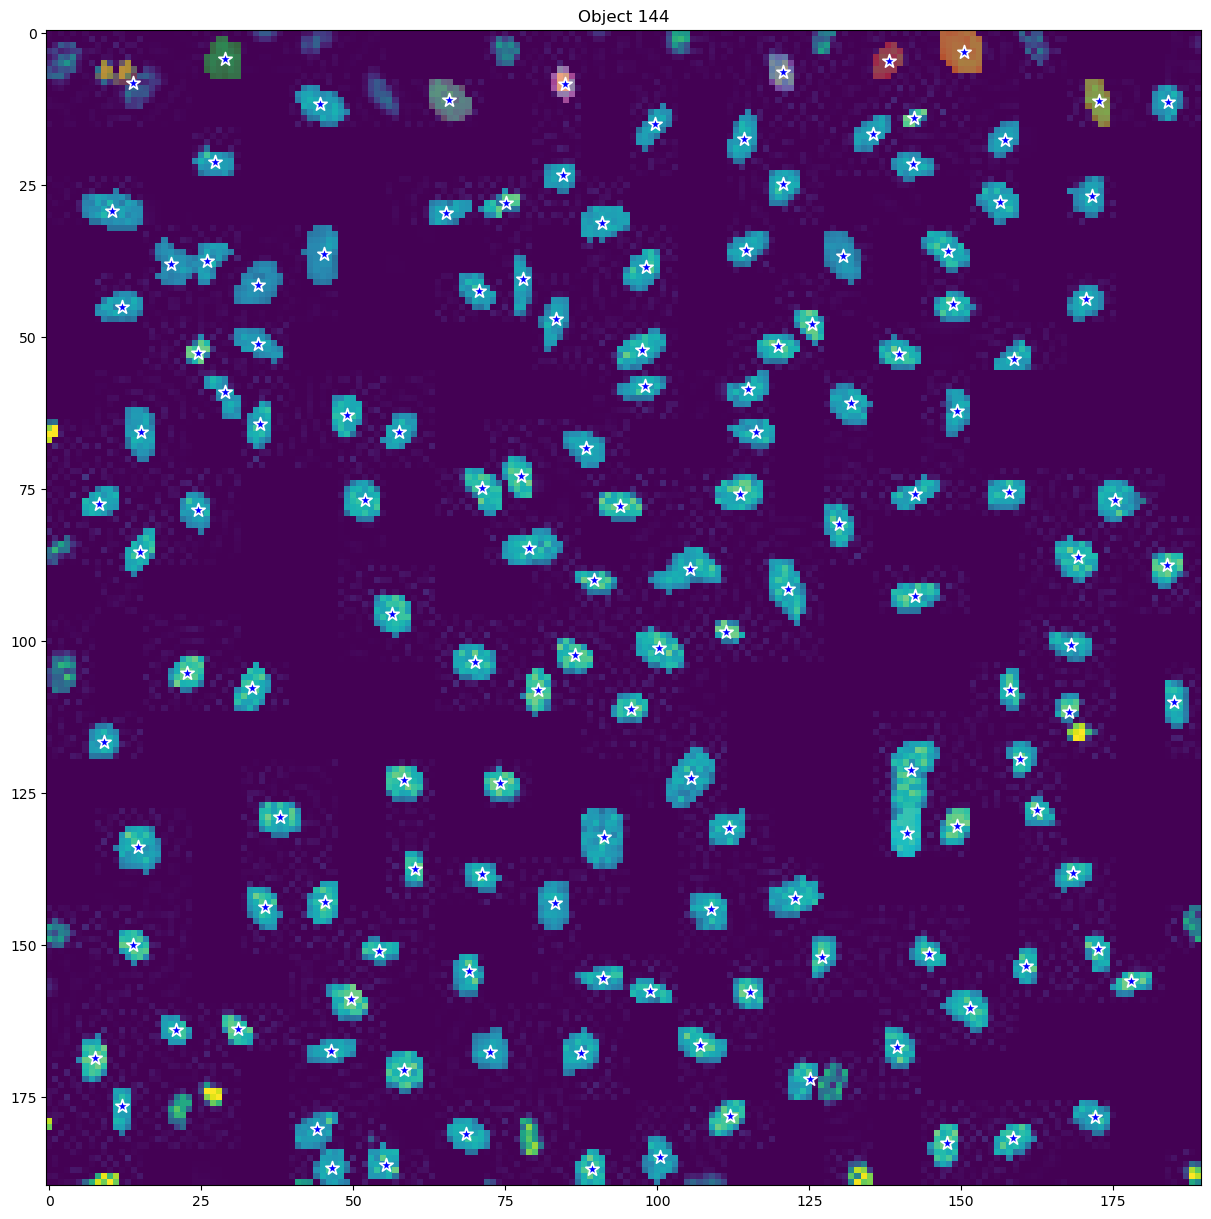

In [11]:
# show the results on the current (interacted) frame
plt.figure(figsize=(15, 15))
# subplot axis
# show the frame
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
# subplot for each object
for i, out_obj_id in enumerate(range(1, ann_obj_idx)):
    tmp_coords = prompts[out_obj_id]["points"]
    tmp_labels = prompts[out_obj_id]["labels"]
    # add title to the subplot
    plt.title(f"Object {out_obj_id}")
    # show the frame
    show_points(tmp_coords, tmp_labels, plt.gca())
    show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)
plt.show()

## 5. Track the objects through frames

In [12]:
print(ann_obj_idx)
# Start recording memory snapshot history
logging.basicConfig(
    format="%(levelname)s:%(asctime)s %(message)s",
    level=logging.INFO,
    datefmt="%Y-%m-%d %H:%M:%S",
)
logger: logging.Logger = logging.getLogger(__name__)
logger.setLevel(level=logging.INFO)

TIME_FORMAT_STR: str = "%b_%d_%H_%M_%S"

# Keep a max of 100,000 alloc/free events in the recorded history
# leading up to the snapshot.
MAX_NUM_OF_MEM_EVENTS_PER_SNAPSHOT: int = 100000
start_record_memory_history(
    logger=logger, max_entries=MAX_NUM_OF_MEM_EVENTS_PER_SNAPSHOT
)
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results

for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(
    inference_state
):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(range(1, ann_obj_idx))
    }

INFO:__main__:Starting snapshot record_memory_history


145


propagate in video: 100%|██████████| 13/13 [01:44<00:00,  8.03s/it]


In [13]:
# delete any prior memory profiling data
delete_recorded_memory_history(
    logger=logger, save_dir=pathlib.Path("../memory_snapshots/").resolve()
)
# clear the memory
del out_mask_logits
del out_obj_ids
del out_frame_idx
torch.cuda.empty_cache()
gc.collect()
# save the memory snapshot to a file
export_memory_snapshot(
    logger=logger, save_dir=pathlib.Path("../memory_snapshots/").resolve()
)
stop_record_memory_history(logger=logger)

INFO:__main__:Deleted memory snapshot file: /home/lippincm/Documents/live_cell_timelapse_apoptosis/3.optimizing_CP/run_sam/memory_snapshots
INFO:__main__:Saving snapshot to local file: /home/lippincm/Documents/live_cell_timelapse_apoptosis/3.optimizing_CP/run_sam/memory_snapshots/pine_Aug_09_14_20_19.pickle
INFO:__main__:Stopping snapshot record_memory_history


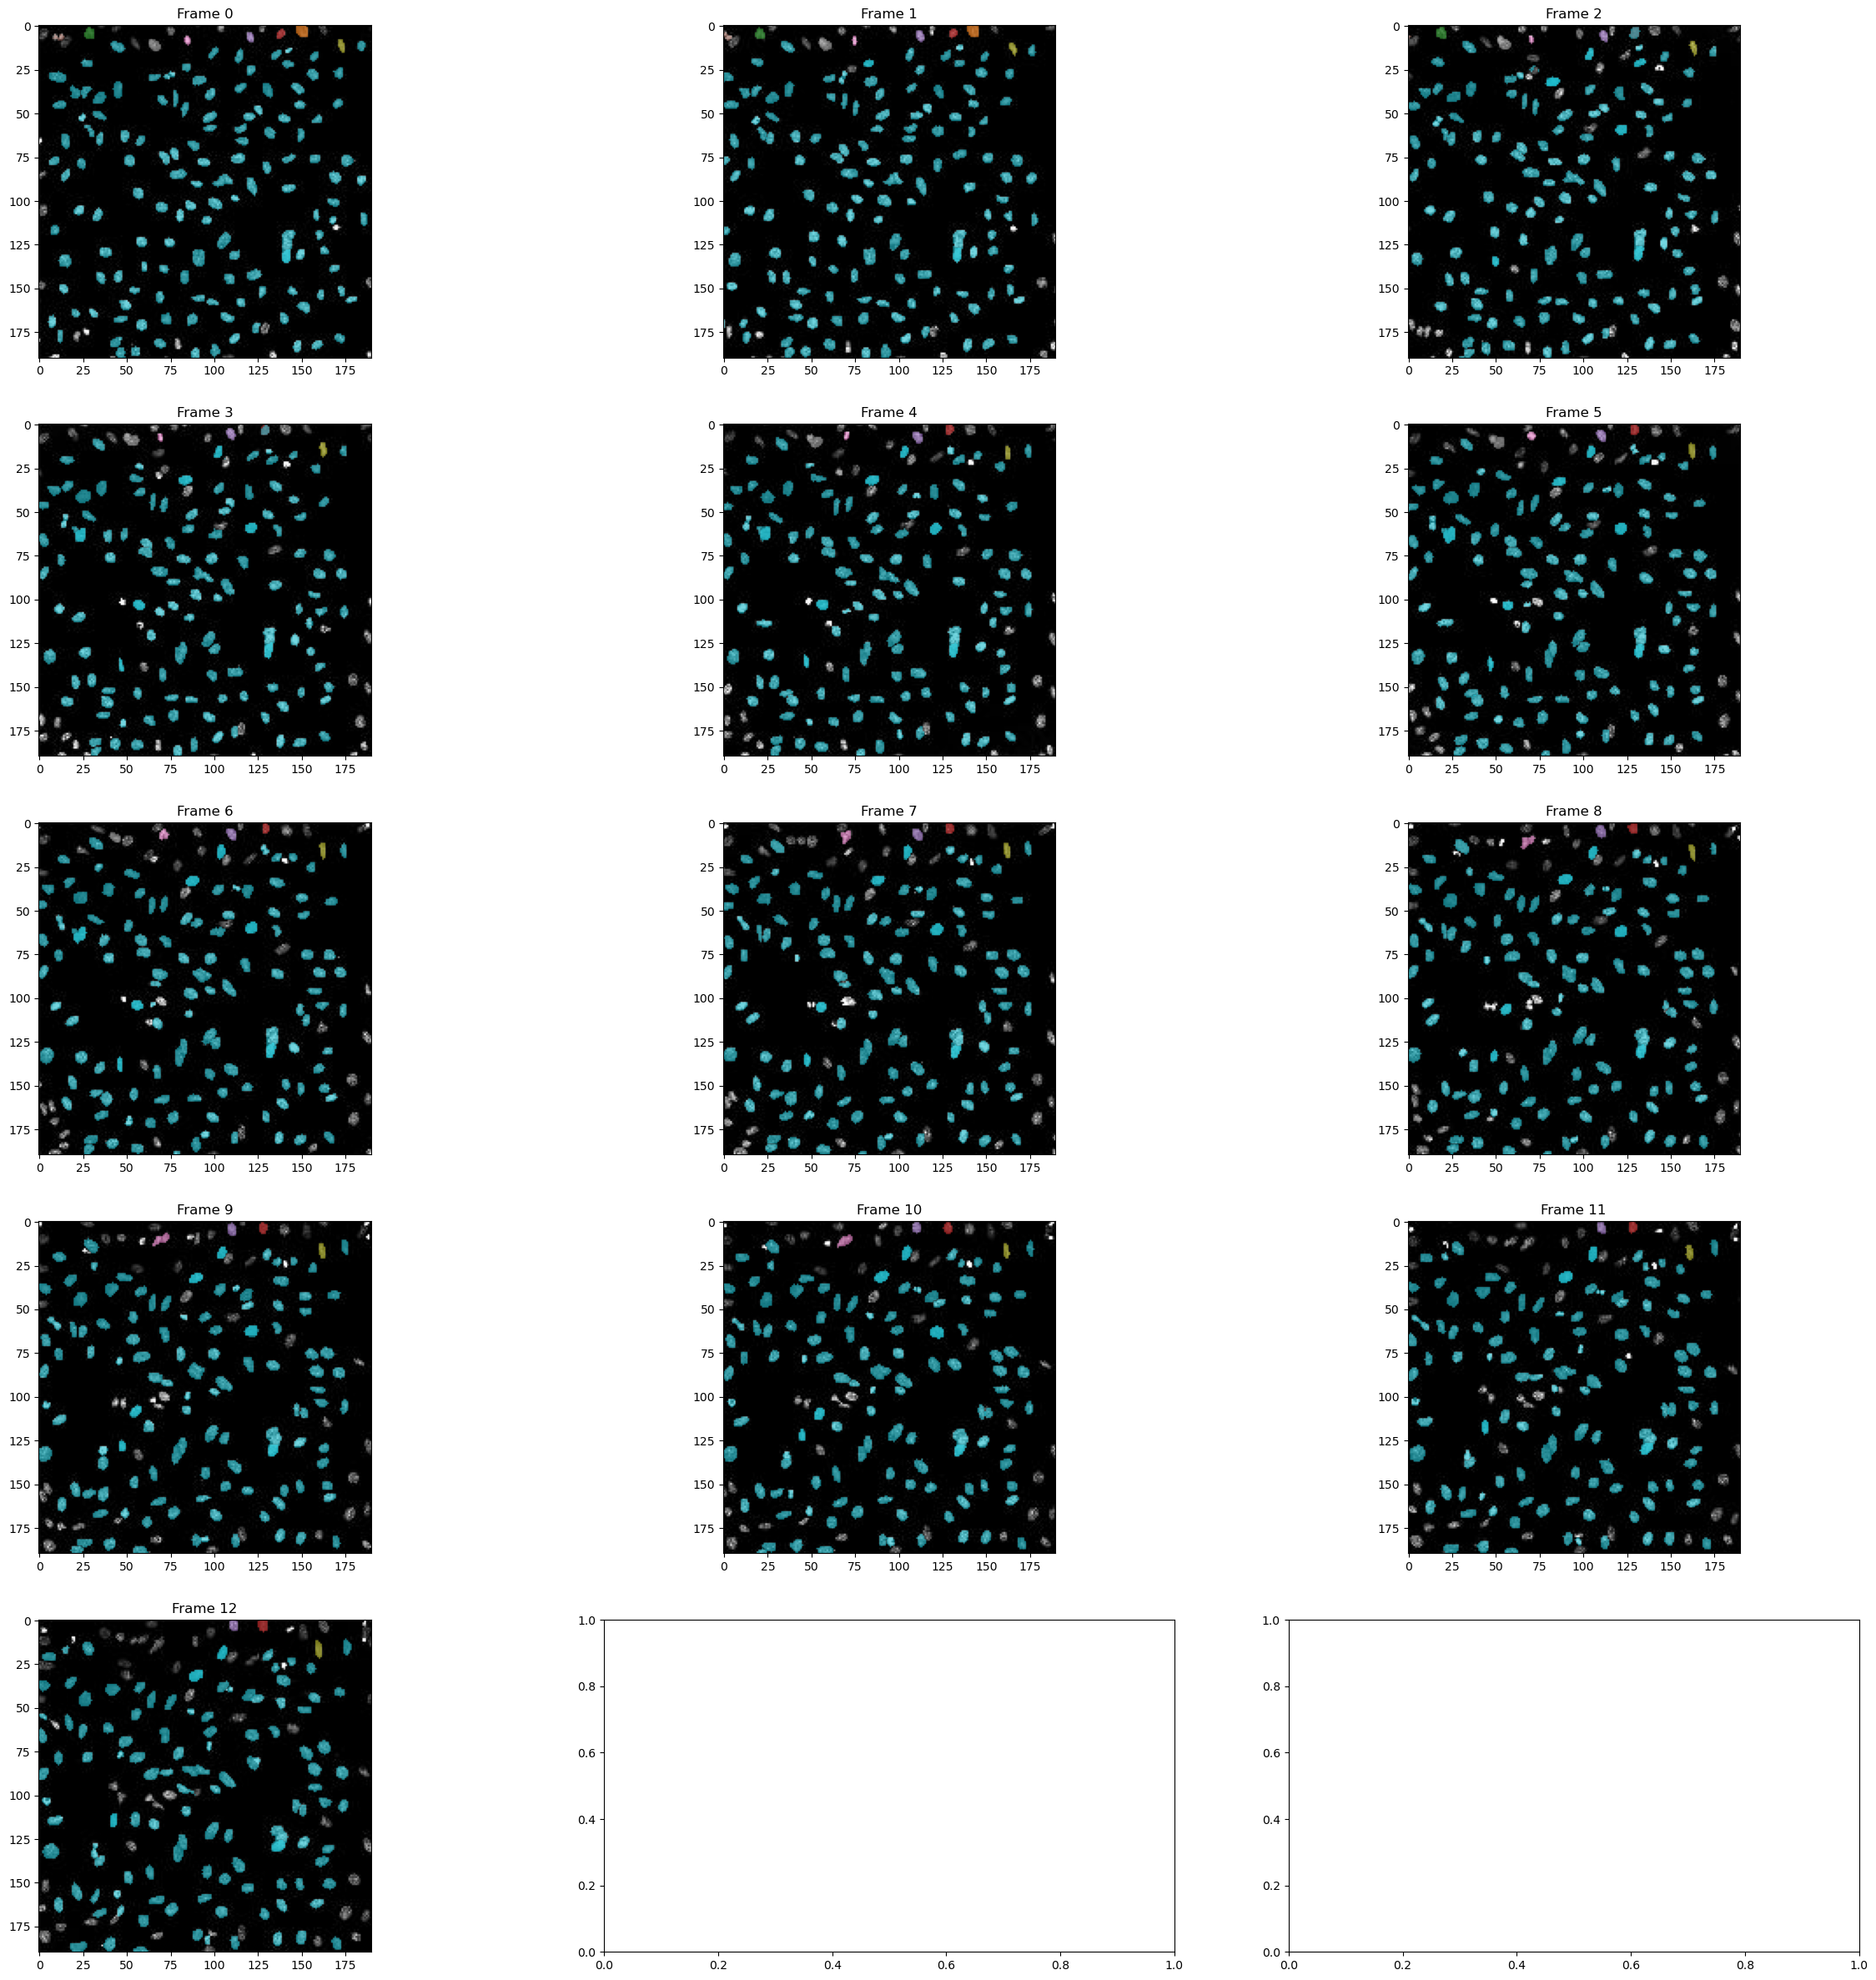

In [14]:
# render the segmentation results every few frames
vis_frame_stride = 1
plt.close("all")
rows = 5
cols = int(np.ceil(len(frame_names) / rows))
fig, ax = plt.subplots(rows, cols, figsize=(30, 30))
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    row, col = divmod(out_frame_idx, cols)
    # add title to the subplot
    ax[row, col].set_title(f"Frame {out_frame_idx}")
    ax[row, col].imshow(
        Image.open(os.path.join(video_dir, frame_names[out_frame_idx])), cmap="gray"
    )
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        # plt.plot(points[0][1], points[0][0], 'o', color='red')
        # show_points(points, labels, ax[row, col])
        show_mask(mask=out_mask, ax=ax[row, col], obj_id=out_obj_id)

## 6. Visualize the tracking and output the data

In [15]:
# add all of the frames together for a rendered gif
# create a list of all the frames
frames = []
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    # create a figure
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(
        Image.open(os.path.join(video_dir, frame_names[out_frame_idx])), cmap="gray"
    )
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(mask=out_mask, ax=ax, obj_id=out_obj_id)
    # add title to the subplot
    ax.set_title(f"Frame {out_frame_idx}")
    # save the figure to a file
    fig.savefig(f"tmp_{out_frame_idx}.png")
    # close the figure
    plt.close(fig)
    # open the image
    img = Image.open(f"tmp_{out_frame_idx}.png")
    # append the image to the frames
    frames.append(img)

fig_path = pathlib.Path("../masks/out.gif").resolve()
pathlib.Path("../masks/").mkdir(exist_ok=True, parents=True)
# save the frames as a gif
frames[0].save(fig_path, save_all=True, append_images=frames[1:], duration=10, loop=0)

# get all files that have tmp in the name
tmp_files = list(Path(".").glob("tmp*.png"))
# delete all the tmp files
[f.unlink() for f in tmp_files]

[None, None, None, None, None, None, None, None, None, None, None, None, None]

In [16]:
img = io.imread(frame_names[0])
h, w = img.shape
print(h, w)
# extract the masks from the video segments
# save the masks to a directory
masks_dir = pathlib.Path("../masks").resolve()
masks_dir.mkdir(exist_ok=True)
for out_frame_idx, frame_masks in video_segments.items():
    # make the frame image
    frame_image = np.zeros((h, w), dtype=np.uint8)
    for out_obj_id, out_mask in frame_masks.items():
        # add each mask to the frame image
        frame_image += (out_mask[0] * 255).astype(np.uint8)
    # save the frame image
    frame_image = Image.fromarray(frame_image)
    frame_image.save(masks_dir / f"{out_frame_idx}.png")

190 190


In [17]:
# extract x,y center of mass of the masks with object id
# save the x,y center of mass to a csv file
csv_file = pathlib.Path("../masks/masks.csv").resolve()
with open(csv_file, mode="w") as f:
    csv_writer = csv.writer(f)
    csv_writer.writerow(["frame", "obj_id", "x", "y"])
    for out_frame_idx, frame_masks in video_segments.items():
        for out_obj_id, out_mask in frame_masks.items():
            out_mask = np.array(out_mask[0], dtype=np.float32)
            # convert the outmask to an image
            regions = regionprops(label(out_mask))
            for region in regions:
                y, x = region.centroid
                csv_writer.writerow([out_frame_idx, out_obj_id, x, y])


df = pd.read_csv(csv_file)
df.head()

,frame,obj_id,x,y
0,0,1,150.111111,2.888889
1,0,2,28.714286,4.342857
2,0,3,137.913043,4.608696
3,0,4,120.500000,6.500000
4,0,5,11.388889,6.555556
